<a href="https://colab.research.google.com/github/Huillotl/Dermis_clasification/blob/main/Enfermedades_de_la_piel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shubhamgoel27/dermnet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dermnet' dataset.
Path to dataset files: /kaggle/input/dermnet


In [ ]:
%ls /root/.cache/kagglehub/datasets/shubhamgoel27/dermnet/versions/1 -l -h

total 8.0K
drwxr-xr-x 25 root root 4.0K Nov 26 07:25 test/
drwxr-xr-x 25 root root 4.0K Nov 26 07:25 train/


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import cv2
import timm
import shutil
import random
import timeit
import pandas as pd
import altair as alt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import albumentations as A

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
root_dir = path+'/train'
destination_dir = '/kaggle/working/dermnet_modified'

# Remove the directory if it already exists to prevent FileExistsError
if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)

shutil.copytree(root_dir, destination_dir)

# Paths
source_dir = '/kaggle/working/dermnet_modified'

print(f"Copied dataset to {destination_dir} successfully!")

Copied dataset to /kaggle/working/dermnet_modified successfully!


In [ ]:
# Function to count images in each class
def count_images(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
    return class_counts

# Plot class distributions
def plot_class_distribution(class_counts, title, output_path=None):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(12, 6))
    plt.barh(classes, counts, color='skyblue')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.title(title)
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

# Count initial image distribution
initial_counts = count_images(source_dir)

In [ ]:
threshold = 1000

augmentation = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL.Image to Tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.ToPILImage()  # Convert Tensor back to PIL.Image
])

# Process each class
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip non-directory files

    # Count images in the class
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    num_images = len(image_files)


    # Augment images if count is less than threshold
    if num_images < threshold:
        additional_images_needed = threshold - num_images
        print(f"Augmenting {class_name}: {additional_images_needed} additional images needed.")

        for i in range(additional_images_needed):
            # Select an image to augment
            img_file = image_files[i % num_images]
            img_path = os.path.join(class_path, img_file)

            # Open the image
            with Image.open(img_path) as img:
                # Apply augmentation
                augmented_img = augmentation(img)

                augmented_img_name = f"{os.path.splitext(img_file)[0]}_augmented_{i + 1}.jpg"
                augmented_img.save(os.path.join(class_path, augmented_img_name))
    else:
        print(f"Skipping {class_name}: {num_images} images found (>= {threshold}).")

Skipping Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 1149 images found (>= 1000).
Augmenting Systemic Disease: 394 additional images needed.
Augmenting Lupus and other Connective Tissue diseases: 580 additional images needed.
Augmenting Light Diseases and Disorders of Pigmentation: 432 additional images needed.
Augmenting Acne and Rosacea Photos: 160 additional images needed.
Augmenting Scabies Lyme Disease and other Infestations and Bites: 569 additional images needed.
Augmenting Herpes HPV and other STDs Photos: 595 additional images needed.
Augmenting Melanoma Skin Cancer Nevi and Moles: 537 additional images needed.
Skipping Eczema Photos: 1235 images found (>= 1000).
Augmenting Urticaria Hives: 788 additional images needed.
Skipping Warts Molluscum and other Viral Infections: 1086 images found (>= 1000).
Augmenting Hair Loss Photos Alopecia and other Hair Diseases: 761 additional images needed.
Augmenting Atopic Dermatitis Photos: 511 additional images need

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for image_name in os.listdir(label_dir):
                    image_path = os.path.join(label_dir, image_name)
                    if os.path.isfile(image_path):
                        self.images.append(image_path)
                        self.labels.append(label)

        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.encoded_labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_label_mapping(self):
        return dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_))))

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import os

# CONFIG
base_dir = path
train_dir = '/kaggle/working/dermnet_modified'
test_dir = os.path.join(base_dir, "test")
num_classes = 23
batch_size = 128  # OJO: Si te da "Out of Memory", baja esto a 64 o 32
num_epochs = 50
learning_rate = 1e-4 # <--- CORREGIDO (Más seguro para Transfer Learning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TRANSFORM (Solo normalización, ya que hiciste aumentación física)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 1. CARGAR DATASETS
full_train_dataset = CustomImageDataset(root_dir=train_dir, transform=transform)
test_dataset = CustomImageDataset(root_dir=test_dir, transform=transform)

# 2. CREAR VALIDACIÓN (Split 80/20)
# Como ya balanceaste físicamente, un random_split simple funciona bien.
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

print(f"Train: {len(train_subset)} | Val: {len(val_subset)} | Test: {len(test_dataset)}")

# 3. LOADERS (Ahora son 3)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

Train: 19668 | Val: 4918 | Test: 4002


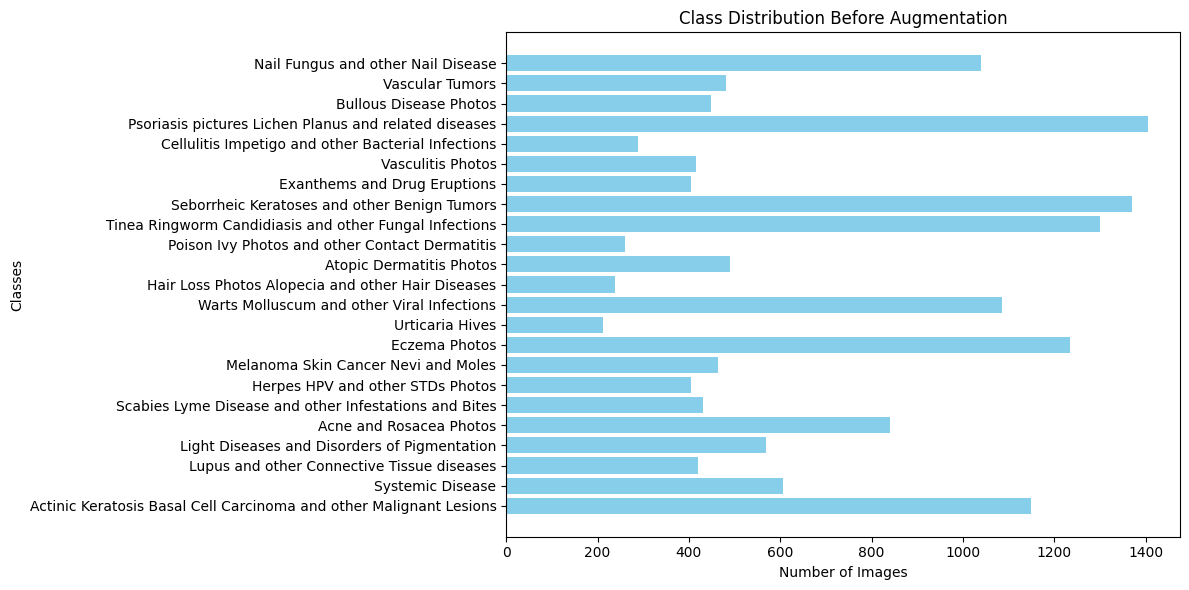

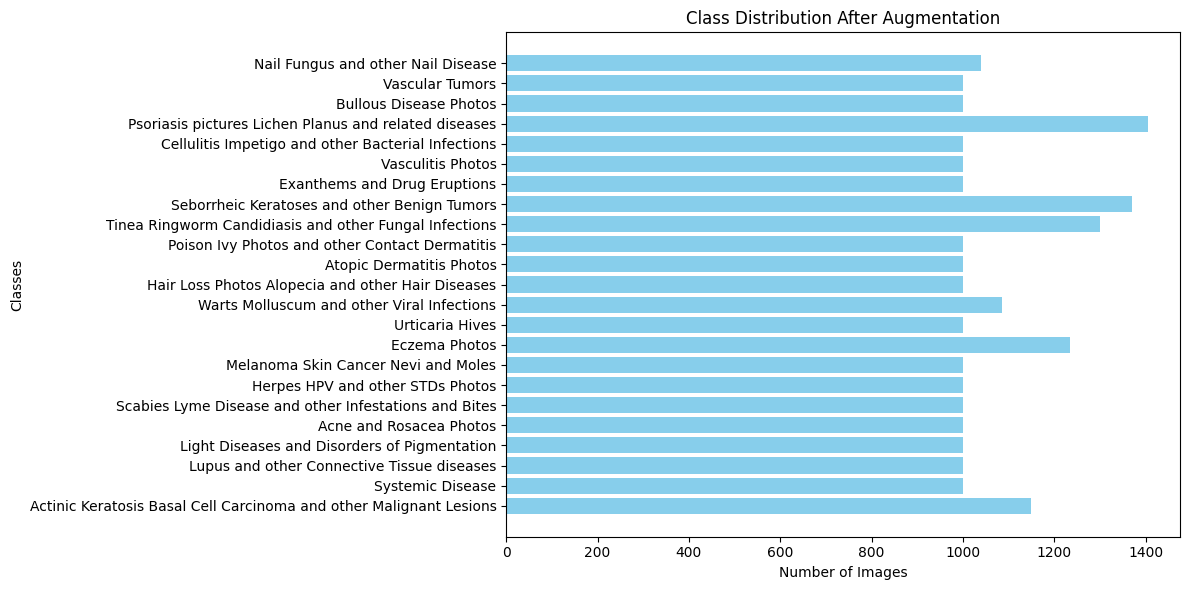

In [ ]:
# Count final image distribution
final_counts = count_images(source_dir)

# Plot distributions before and after augmentation
plot_class_distribution(initial_counts, 'Class Distribution Before Augmentation')
plot_class_distribution(final_counts, 'Class Distribution After Augmentation')

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# 1. CARGAR ALEXNET PRE-ENTRENADA
# Usamos los pesos por defecto (ImageNet)
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# 2. INSPECCIONAR (Opcional)
print(model)

# 3. CONGELAR PESOS (FEATURE EXTRACTION)
# Como es una red antigua, suele ser mejor congelar todo al principio
for param in model.parameters():
    param.requires_grad = False

# 4. MODIFICAR EL CLASIFICADOR
# AlexNet tiene una estructura de salida idéntica a VGG:
# (0) Dropout -> (1) Linear -> (2) ReLU -> (3) Dropout -> (4) Linear -> (5) ReLU -> (6) Linear

# Accedemos a la última capa (índice 6)
# La entrada estándar de AlexNet en esa capa es 4096 neuronas.
model.classifier[6] = nn.Linear(in_features=4096, out_features=23)

# 5. MOVER A GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("AlexNet cargada y modificada para 23 clases.")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score # <--- NUEVA LIBRERÍA

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

# ==========================================
# 2. FUNCIÓN DE ENTRENAMIENTO
# ==========================================
def train(model, loader):
    model.train()
    running_loss = 0.0
    correct = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)

        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        # Acumular Loss ponderado por tamaño del batch
        running_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    return running_loss / len(loader.dataset), correct / len(loader.dataset)

# ==========================================
# 3. FUNCIÓN DE EVALUACIÓN (CON F1-SCORE)
# ==========================================
def evaluate(model, loader):
    model.eval()
    correct = 0
    y_true = []
    y_pred = [] # Usamos predicciones "duras" (argmax) para F1

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)

            # Obtenemos la clase ganadora
            pred = out.argmax(1)

            correct += (pred == y).sum().item()

            # Guardamos para calcular F1 al final
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    acc = correct / len(loader.dataset)

    # CÁLCULO DEL F1 SCORE
    # 'weighted': Pondera por el número de muestras reales de cada clase.
    # 'macro': Calcula el promedio simple (útil si quieres tratar todas las clases por igual)
    f1 = f1_score(y_true, y_pred, average='weighted')

    return acc, f1

# ==========================================
# 4. BUCLE PRINCIPAL
# ==========================================

# Almacenamiento de métricas
train_losses, train_accuracies = [], []
val_accuracies, val_f1_scores = [], [] # Cambiamos nombre de la lista

# Variables para Checkpoint
best_val_f1 = 0.0 # Usaremos F1 para decidir cuál es el mejor modelo (es más robusto que Accuracy)

print("Iniciando entrenamiento...")

for epoch in range(num_epochs):
    # 1. Entrenar
    train_loss, train_acc = train(model, train_loader)

    # 2. Validar
    val_acc, val_f1 = evaluate(model, test_loader)

    # Guardar en listas
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}: Loss={train_loss:.4f} | Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f} | Val F1={val_f1:.4f}")

    # 3. Scheduler (Monitoreamos F1 o Acc, aquí uso F1)
    scheduler.step(val_f1)

    # 4. Guardar el mejor modelo basado en F1 Score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"--> ¡Récord! Modelo guardado (Mejor F1: {best_val_f1:.4f})")

# ==========================================
# 5. EVALUACIÓN FINAL (TEST SET)
# ==========================================
print("\nCargando el mejor modelo para evaluación final...")
model.load_state_dict(torch.load('best_model.pth'))
test_acc, test_f1 = evaluate(model, test_loader)
print(f"Resultado Final en Test -> Acc: {test_acc:.4f}, F1-Score: {test_f1:.4f}")

Iniciando entrenamiento...
Epoch 1: Loss=1.6488 | Train Acc=0.4914 | Val Acc=0.4120 | Val F1=0.4023
--> ¡Récord! Modelo guardado (Mejor F1: 0.4023)
Epoch 2: Loss=1.6429 | Train Acc=0.4967 | Val Acc=0.4143 | Val F1=0.4021
Epoch 3: Loss=1.6363 | Train Acc=0.4985 | Val Acc=0.4115 | Val F1=0.3971
Epoch 4: Loss=1.6363 | Train Acc=0.4976 | Val Acc=0.4145 | Val F1=0.4031
--> ¡Récord! Modelo guardado (Mejor F1: 0.4031)
Epoch 5: Loss=1.6319 | Train Acc=0.4980 | Val Acc=0.4093 | Val F1=0.3983
Epoch 6: Loss=1.6273 | Train Acc=0.4953 | Val Acc=0.4140 | Val F1=0.4029


KeyboardInterrupt: 

### Implementing VGG16 Model

In [ ]:
import tensorflow as tf
import os

# CONFIGURACIÓN
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATA_DIR = '/kaggle/working/dermnet_modified' # Tu carpeta de entrenamiento

# 1. CARGAR TRAIN (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,      # Decimos que queremos reservar el 20%
    subset="training",         # Pedimos la parte de ENTRENAMIENTO
    seed=123,                  # ¡CRÍTICO! Debe ser el mismo número en ambos
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'   # 'int' para sparse, 'categorical' para one-hot
)

# 2. CARGAR VALIDACIÓN (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,      # Mismo porcentaje
    subset="validation",       # Pedimos la parte de VALIDACIÓN
    seed=123,                  # ¡CRÍTICO! Si cambias esto, mezclas datos
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# 3. CARGAR TEST (Carpeta separada)
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/dermnet/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False              # No barajar el test para evaluar en orden
)

Found 24586 files belonging to 23 classes.
Using 19669 files for training.
Found 24586 files belonging to 23 classes.
Using 4917 files for validation.
Found 4002 files belonging to 23 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# CONFIGURACIÓN
IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = 23

# ============================================================
# 1. CARGAR LA BASE (FEATURE EXTRACTOR)
# ============================================================
# include_top=False: Descarga el modelo SIN las capas densas finales (las de 1000 clases).
# weights='imagenet': Usa los pesos aprendidos.
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')

# ============================================================
# 2. CONGELAR LOS PESOS (FREEZE)
# ============================================================
# Esto es vital para Transfer Learning. Evita romper los pesos de
# las convoluciones al inicio del entrenamiento.
base_model.trainable = False

# ============================================================
# 3. AÑADIR TU PROPIA CABEZA (CLASSIFIER)
# ============================================================
vgg16_model = models.Sequential()

# A. Preprocesamiento específico de VGG16
# VGG espera píxeles 0-255 centrados en cero (BGR), NO 0-1 RGB.
# Esta función hace la magia automáticamente dentro del modelo.
vgg16_model.add(layers.Lambda(tf.keras.applications.vgg16.preprocess_input, input_shape=IMG_SHAPE))

# B. El modelo base
vgg16_model.add(base_model)

# C. Tus capas clasificadoras (Replicando la estructura clásica de VGG)
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(4096, activation='relu'))
vgg16_model.add(layers.Dropout(0.5))
vgg16_model.add(layers.Dense(4096, activation='relu'))
vgg16_model.add(layers.Dropout(0.5))

# D. Salida final
vgg16_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# ============================================================
# 4. COMPILAR
# ============================================================
vgg16_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

vgg16_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 23)             │        94,231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,354,775 (512.52 MB)

 Trainable params: 119,640,087 (456.39 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Definir Callbacks (Guardianes del entrenamiento)
callbacks_list_vgg = [
    # Detener si val_loss no mejora en 5 épocas
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),

    # Guardar el mejor modelo (por si se desconecta Colab)
    ModelCheckpoint('mejor_vgg16.keras', monitor='val_loss', save_best_only=True)
]

# Entrenar el modelo VGG16
history_vgg = vgg16_model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,

    callbacks=callbacks_list_vgg
)

Epoch 1/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 220s 326ms/step - accuracy: 0.1356 - loss: 10.3854 - val_accuracy: 0.3036 - val_loss: 2.4619
Epoch 2/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 180s 292ms/step - accuracy: 0.2766 - loss: 2.7621 - val_accuracy: 0.3358 - val_loss: 2.4149
Epoch 3/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 215s 349ms/step - accuracy: 0.3765 - loss: 2.3534 - val_accuracy: 0.3803 - val_loss: 2.3331
Epoch 4/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 178s 290ms/step - accuracy: 0.4687 - loss: 2.0165 - val_accuracy: 0.3938 - val_loss: 2.3143
Epoch 5/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 147s 238ms/step - accuracy: 0.5433 - loss: 1.7618 - val_accuracy: 0.4028 - val_loss: 2.3889
Epoch 6/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 146s 238ms/step - accuracy: 0.6038 - loss: 1.5805 - val_accuracy: 0.4220 - val_loss: 2.3188
Epoch 7/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 147s 239ms/step - accuracy: 0.6561 - loss: 1.4399 - val_accuracy: 0.4373 - val_loss: 2.3385
Epoch 8/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 164s 267ms/step - accuracy: 0.6985 

In [ ]:
from tensorflow.keras import layers, models, optimizers

def crear_alexnet(num_clases):
    model = models.Sequential()

    # --- 1. BLOQUE DE PREPROCESAMIENTO ---
    # Input shape debe ser (224, 224, 3) según configuraste tu dataset
    model.add(layers.Input(shape=(224, 224, 3)))

    # Data Augmentation (Integrado en el modelo como discutimos)
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))
    model.add(layers.RandomZoom(0.1))

    # Normalización: AlexNet espera valores centrados, pero rescaling a [0,1] funciona bien
    model.add(layers.Rescaling(1./255))

    # --- 2. BLOQUE CONVOLUCIONAL (Feature Extraction) ---

    # Capa 1: Filtro gigante (11x11) para capturar rasgos grandes. Stride 4 reduce dimensión rápido.
    model.add(layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Capa 2: Filtro 5x5
    model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Capa 3: Filtro 3x3
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

    # Capa 4: Filtro 3x3
    model.add(layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))

    # Capa 5: Filtro 3x3 + MaxPool final
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # --- 3. BLOQUE CLASIFICADOR (Fully Connected) ---
    model.add(layers.Flatten())

    # Densa 1: 4096 neuronas (Estándar AlexNet) + Dropout para evitar Overfitting
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Densa 2: 4096 neuronas
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Capa de Salida: Tus 23 clases
    model.add(layers.Dense(num_clases, activation='softmax'))

    return model

# Crear la instancia del modelo
model = crear_alexnet(num_clases=23)

# Compilar (Usando un Learning Rate bajo porque AlexNet es grande)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:

from sklearn.utils import class_weight

ruta_train = path+'/train'
clases = sorted(os.listdir(ruta_train)) # Asegura orden alfabético (0, 1, 2...)

y_train_indices = []
for i, clase in enumerate(clases):
    n_archivos = len(os.listdir(os.path.join(ruta_train, clase)))
    # Añadimos el índice 'i' tantas veces como archivos tenga esa clase
    y_train_indices.extend([i] * n_archivos)

y_train_indices = np.array(y_train_indices)


pesos_calculados = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

# 3. Convertir a un diccionario (formato que exige Keras)
# El formato debe ser: {0: 1.5, 1: 0.8, ...}
class_weights_dict = dict(enumerate(pesos_calculados))

# Verificación rápida
print("Pesos generados para las primeras 5 clases:")
for i in range(5):
    print(f"Clase '{clases[i]}': Peso {class_weights_dict[i]:.2f}")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


callbacks_list = [

    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('mejor_alexnet.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=tesst_ds,
    class_weight=class_weights_dict,
    callbacks=callbacks_list
)

In [ ]:
import gc

# 1. Borrar las variables que ocupan memoria
# Reemplaza 'model', 'loss', 'optimizer' con los nombres reales de tus variables
try:
    del vgg16_model
    #del optimizer
    #del loss
except NameError:
    print("Las variables ya no existen.")

# 2. Recolección de Basura de Python (Limpia la RAM del sistema)
gc.collect()

# 3. Limpiar la Caché de PyTorch (Limpia la VRAM de la GPU)
torch.cuda.empty_cache()

# 4. Verificar
print(f"Memoria asignada: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Memoria reservada: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Las variables ya no existen.
Memoria asignada: 0.00 MB
Memoria reservada: 0.00 MB


In [ ]:
# CONFIG

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)#, verbose=True)

# TRAINING & VALIDATION FUNCTIONS
def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    acc = correct / len(loader.dataset)
    try:
        auc = roc_auc_score(np.eye(num_classes)[y_true], np.eye(num_classes)[y_pred], multi_class='ovr')
    except:
        auc = 0.0
    return acc, auc

# METRICS STORAGE
train_losses, train_accuracies = [], []
val_accuracies, val_aucs = [], []
test_accuracies = []

# TRAINING LOOP
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader)
    val_acc, val_auc = evaluate(model, val_loader)
    test_acc, _ = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val AUC={val_auc:.4f}, Test Acc={test_acc:.4f}")

    scheduler.step(val_acc)




Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


Epoch 1: Loss=2.6207, Train Acc=0.2265, Val Acc=0.2034, Val AUC=0.5542, Test Acc=0.2186
Epoch 2: Loss=2.3258, Train Acc=0.3031, Val Acc=0.2728, Val AUC=0.5791, Test Acc=0.2594
Epoch 3: Loss=2.1667, Train Acc=0.3431, Val Acc=0.2137, Val AUC=0.5696, Test Acc=0.2154
Epoch 4: Loss=2.0476, Train Acc=0.3840, Val Acc=0.2918, Val AUC=0.5924, Test Acc=0.2906
Epoch 5: Loss=1.9585, Train Acc=0.4076, Val Acc=0.2391, Val AUC=0.5825, Test Acc=0.2409
Epoch 6: Loss=1.8626, Train Acc=0.4335, Val Acc=0.3560, Val AUC=0.6284, Test Acc=0.3493
Epoch 7: Loss=1.7862, Train Acc=0.4548, Val Acc=0.3143, Val AUC=0.6111, Test Acc=0.3176
Epoch 8: Loss=1.7011, Train Acc=0.4813, Val Acc=0.3634, Val AUC=0.6501, Test Acc=0.3631
Epoch 9: Loss=1.6262, Train Acc=0.5012, Val Acc=0.3621, Val AUC=0.6329, Test Acc=0.3241
Epoch 10: Loss=1.5554, Train Acc=0.5174, Val Acc=0.4148, Val AUC=0.6662, Test Acc=0.4138
Epoch 11: Loss=1.4860, Train Acc=0.5384, Val Acc=0.3708, Val AUC=0.6541, Test Acc=0.3766
Epoch 12: Loss=1.3874, Train A

KeyboardInterrupt: 

In [ ]:
checkpoint_path = '/kaggle/working/best_model_weights.pth'
torch.save(model.state_dict(), checkpoint_path)

In [ ]:
history_data = {
    'epoch': list(range(1, len(train_losses) + 1)),
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies,
    'val_auc': val_aucs,
    'test_accuracy': test_accuracies
}

# Crear un DataFrame de pandas
history_df = pd.DataFrame(history_data)

# Definir la ruta donde se guardará el archivo
output_path = '/kaggle/working/training_history.csv'

# Guardar en formato CSV
history_df.to_csv(output_path, index=False)

print(f"Historial de entrenamiento guardado en {output_path}")

Historial de entrenamiento guardado en /kaggle/working/training_history.csv


In [ ]:
lossANet=[2.1290,2.0893,2.0594,2.0284,2.0037,1.9818,1.9611,1.9398,1.9208,1.9088,1.8975,1.8778,1.8646,1.8514,1.8416,1.8305,1.8178,1.8031,1.8047,1.7892,1.7802,1.7726,1.7735,1.7542,1.7502,1.7441,1.7344,1.7254,1.7216,1.7157,1.7066,1.6973,1.6775,1.6775,1.6767,1.6767,1.6659,1.6843,1.6738,1.6611,1.6625,1.6620,1.6515,1.6288,1.6488,1.6429,1.6363,1.6363,1.6319,1.6273]
TAccANet=[0.3557,0.3625,0.3727,0.3849,0.3911,0.3967,0.4053,0.4155,0.4181,0.4194,0.4260,0.4275,0.4303,0.4333,0.4371,0.4400,0.4496,0.4507,0.4485,0.4545,0.4565,0.4586,0.4547,0.4676,0.4651,0.4658,0.4710,0.4718,0.4755,0.4724,0.4775,0.4828,0.4916,0.4845,0.4864,0.4854,0.4911,0.4856,0.4889,0.4912,0.4906,0.4891,0.4933,0.5017,0.4914,0.4967,0.4985,0.4976,0.4980,0.4953]
VAccANet=[0.3473,0.3586,0.3576,0.3631,0.3698,0.3643,0.3748,0.3771,0.3786,0.3801,0.3851,0.3858,0.3851,0.3848,0.3868,0.3921,0.3868,0.3956,0.3926,0.3958,0.3971,0.3938,0.4035,0.4023,0.4038,0.4010,0.4020,0.4075,0.4073,0.4033,0.4058,0.4045,0.4080,0.4080,0.4068,0.4108,0.4120,0.4110,0.4060,0.4115,0.4088,0.4115,0.4095,0.4113,0.4120,0.4143,0.4115,0.4145,0.4093,0.4140]
TAccvgg=[ 0.1356,0.2766,0.3765,0.4687,0.5433,0.6038,0.6561,0.6985,0.7335]
Losvgg=[ 10.3854,2.7621,2.3534,2.0165,1.7618,1.5805,1.4399,1.2963,1.1393]
VAccvgg=[ 0.3036,0.3358,0.3803,0.3938,0.4028,0.4220,0.4373,0.4380,0.4343]
len(VAccANet)==len(TAccANet)

True

In [ ]:
import pandas as pd
histR50=pd.read_csv('/content/training_history.csv')

train_loss_R50 = histR50['train_loss'].to_numpy()
train_accuracy_R50 = histR50['train_accuracy'].to_numpy()
val_accuracy_R50 = histR50['val_accuracy'].to_numpy()

print("train_loss_R50 (array): ", train_loss_R50)
print("train_accuracy_R50 (array): ", train_accuracy_R50)
print("val_accuracy_R50 (array): ", val_accuracy_R50)

train_loss_R50 (array):  [2.62066676 2.32583357 2.16670318 2.04763853 1.95848628 1.86255008
 1.78615906 1.70108168 1.62615275 1.55539378 1.48596604 1.38739049
 1.32298056 1.24129915 1.17566306 1.12291444 1.02849955 0.72997953
 0.60167189 0.53738721 0.51253564 0.44472845 0.40555459 0.37136256
 0.22036553 0.17214931 0.16338328 0.14657903 0.10774745 0.08834439
 0.08232485 0.08517528 0.08520137 0.08290519 0.07128384 0.06492418]
train_accuracy_R50 (array):  [0.22651667 0.30309361 0.34310968 0.38400964 0.40755323 0.43350743
 0.45480112 0.4813178  0.50116513 0.51739654 0.53836882 0.57010848
 0.58642025 0.61438329 0.62675773 0.64435516 0.67513057 0.7705906
 0.80642828 0.82507031 0.83077541 0.85383688 0.86789875 0.87488951
 0.92736039 0.94576135 0.9458417  0.95210928 0.96376055 0.96898353
 0.97034954 0.96898353 0.96994777 0.96809964 0.97292085 0.97501004]
val_accuracy_R50 (array):  [0.20340617 0.27281491 0.21368895 0.29177378 0.23907455 0.35604113
 0.31426735 0.36343188 0.36214653 0.41484576 0.

In [ ]:
AccScratch=[ 0.0484,0.0993,0.0936,0.1071,0.1285, 0.1382,0.1661,0.1740,0.1876,0.2029,0.2081,0.2195,0.2342,0.2429,0.2604,0.2739,0.2883,0.3069,0.3249,0.3382,0.3473,0.3624,0.3776,0.3972,0.4212,0.4385,0.4544,0.4698,0.4890,0.4995,0.5155 ]
LossScratch=[3.1133,3.0412,3.0164, 2.9511,2.8658,2.8168,2.7625,2.7234,2.6676,2.6261,2.5709,2.5301,2.4747,2.4298,2.3658,2.3068,2.2509,2.1831,2.1115,2.0384,2.0080,1.9360,1.8575,1.7982,1.7017,1.6467,1.5732,1.5201,1.4537,1.4043,1.3487 ]
VaccScratch = [
    0.0805, 0.0507, 0.0807, 0.1187, 0.1287, 0.1604, 0.1729, 0.1892, 0.2004, 0.2126,
    0.2069, 0.2231, 0.2221, 0.2216, 0.2381, 0.2414, 0.2571, 0.2531, 0.2694, 0.2791,
    0.2791, 0.2869, 0.2989, 0.3031, 0.3088, 0.3373, 0.3313, 0.3278, 0.3331, 0.3476,
    0.3386
]
len(VaccScratch)==len(AccScratch)

True

In [ ]:
import matplotlib.pyplot as plt

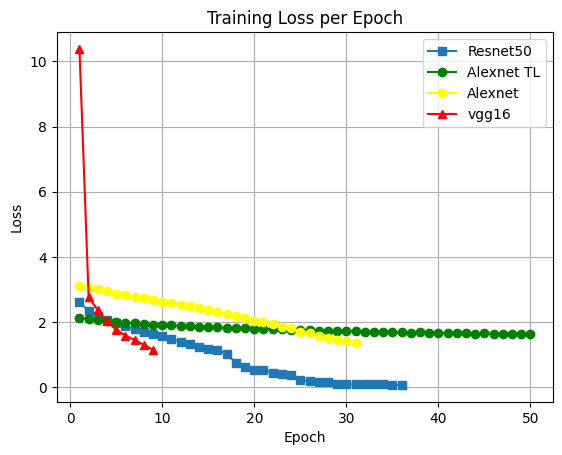

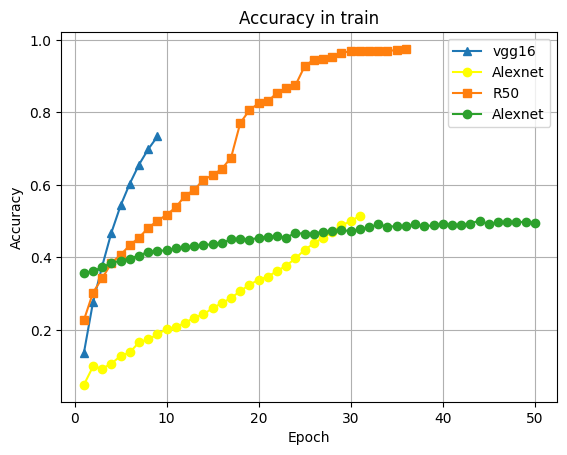

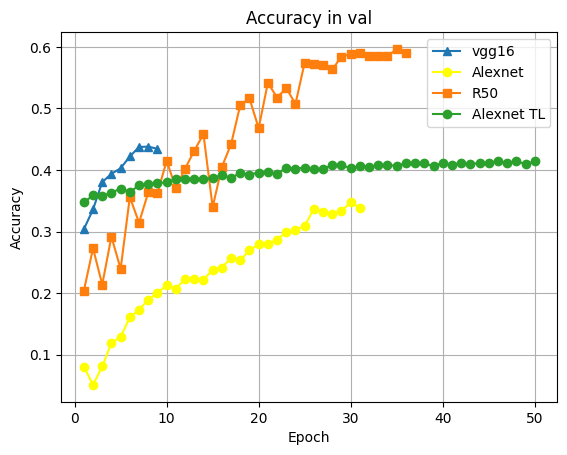

In [ ]:
# PLOT LOSS
plt.figure()
plt.plot(range(1, len(train_loss_R50)+1), train_loss_R50, label='Resnet50', marker='s')
plt.plot(range(1, len(lossANet)+1), lossANet, label='Alexnet TL', marker='o',color='green')
plt.plot(range(1, len(LossScratch)+1), LossScratch, label='Alexnet', marker='o',color='yellow')
plt.plot(range(1, len(Losvgg)+1), Losvgg, label='vgg16', marker='^',color='red')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# PLOT ACCURACY
plt.figure()
plt.plot(range(1, len(TAccvgg)+1), TAccvgg, label='vgg16', marker='^')
plt.plot(range(1, len(LossScratch)+1), AccScratch, label='Alexnet', marker='o',color='yellow')
plt.plot(range(1, len(train_accuracy_R50)+1), train_accuracy_R50, label='R50', marker='s')
plt.plot(range(1, len(TAccANet)+1), TAccANet, label='Alexnet', marker='o')
plt.title("Accuracy in train")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# PLOT AUC
plt.figure()
plt.plot(range(1, len(TAccvgg)+1), VAccvgg, label='vgg16', marker='^')
plt.plot(range(1, len(LossScratch)+1), VaccScratch, label='Alexnet', marker='o',color='yellow')
plt.plot(range(1, len(val_accuracy_R50)+1), val_accuracy_R50, label='R50', marker='s')
plt.plot(range(1, len(TAccANet)+1), VAccANet, label='Alexnet TL', marker='o')
plt.title("Accuracy in val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.show()

| Métrica | **ResNet-50 (Transfer Learning)** | **VGG-16 (Transfer Learning)** | **AlexNet (Transfer Learning)** | **AlexNet (Desde Cero / Scratch)** |
| :--- | :--- | :--- | :--- | :--- |
| **Epochs Entrenados** | 35 | 9 | 50 | 31 |
| **Mejor Accuracy (Train)** | **97.50%** | 73.35% | 50.17% | 51.55% |
| **Mejor Accuracy (Val)** | **59.67%** | **43.80%** | **41.45%** | 🔴 **34.76%** |
| **Gap (Overfitting)** | ~38% (Extremo) | ~30% (Alto) | ~8% (Bajo) | ~17% (Medio) |
| **Mejor Loss (Train)** | 0.0649 | 1.1393 | 1.6273 | 1.3487 |
| **Velocidad de Convergencia** | Rápida | **Explosiva** | Lenta | Muy Lenta e Inestable |
| **Conclusión** | Potente pero memoriza demasiado | **Balance Ideal Tiempo/Resultados** | Estable pero limitada | **Insuficiente (Necesita pesos pre-entrenados)** |